In [2]:
import data_utils as my_utils
import cv2
import dlib
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D
from keras.models import Sequential, Model
from keras.utils import np_utils
from skimage.feature import hog
import sklearn
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
df = pd.read_csv("fer2013.csv")
emotion_labels = {0: "Angry", 1: "Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}
labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [6]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
emotion_labels

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [8]:
# process the training, validation and test data
x_train, y_train = my_utils.process_data(df, 'Training')
x_validation, y_validation = my_utils.process_data(df, 'PublicTest')
x_test, y_test = my_utils.process_data(df, "PrivateTest")

/Users/ritvikareddy 1/Documents/GitHub/ml-project/venv/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/ritvikareddy 1/Documents/GitHub/ml-project/data_utils.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lambda pixel_str: np.fromstring(pixel_str, sep=' '))


In [9]:
# get face landmarks
x_train_landmarks = my_utils.extract_landmark_features(x_train)
x_validation_landmarks = my_utils.extract_landmark_features(x_validation)
x_test_landmarks = my_utils.extract_landmark_features(x_test)

In [10]:
# cnn for just the raw pixels
# Input layer 1
images_nn = Input(shape=(48,48,1))

# Layer 1
images_conv1 = Conv2D(64, 3, kernel_initializer='he_normal', activation='relu')(images_nn)
images_batchnorm1 = BatchNormalization()(images_conv1)
images_pool1 = MaxPool2D(pool_size=(3,3), strides=2)(images_batchnorm1)

# Layer 2
images_conv2 = Conv2D(128, 3, activation='relu')(images_pool1)
images_batchnorm2 = BatchNormalization()(images_conv2)
images_pool2 = MaxPool2D(pool_size=(3,3), strides=2)(images_batchnorm2)

# Layer 3
images_conv3 = Conv2D(256, 3, activation='relu')(images_pool2)
images_batchnorm3 = BatchNormalization()(images_conv3)
images_pool3 = MaxPool2D(pool_size=(3,3), strides=2)(images_batchnorm3)
images_dropout1 = Dropout(0.6)(images_pool3)

# Flatten
images_flat1 = Flatten()(images_dropout1)

# Fully Connected Layer 1
images_dense1 = Dense(4096, activation='relu')(images_flat1)
images_dropout2 = Dropout(0.6)(images_dense1)

# Fully Connected Layer 2
images_dense2 = Dense(1024, activation='relu')(images_dropout2)
images_batchnorm4 = BatchNormalization()(images_dense2)

# Fully Connected Layer 3
images_dense3 = Dense(128, activation='relu')(images_batchnorm4)


# cnn for landmark features
# input shape will be 68*2 (from landamrks)
# Input Layer
landmarks_features_nn = Input(shape=(68,2))

# Flatten
landmarks_features_flat1 = Flatten()(landmarks_features_nn)

# Fully Connected Layer 4
landmarks_features_dense1 = Dense(1024, activation='relu')(landmarks_features_flat1)
landmarks_features_batchnorm1 = BatchNormalization()(landmarks_features_dense1)

# Fully Connected Layer 5
landmarks_features_dense2 = Dense(128, activation='relu') (landmarks_features_batchnorm1)
landmarks_features_batchnorm2 = BatchNormalization()(landmarks_features_dense2)

# merge final outputs from both networks
merged_net = keras.layers.merge.concatenate([images_dense3, landmarks_features_batchnorm2],
                                           axis=-1)

# Output Layer
output_layer = Dense(7, activation='softmax')(merged_net)

model = Model(inputs=[images_nn, landmarks_features_nn], outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 22, 22, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
# save best weights
checkpoint = ModelCheckpoint(filepath='cnn_arch2_landmarks', verbose=2, save_best_only=True)

# num epochs
epochs = 10

# run model
model_history = model.fit([x_train, x_train_landmarks], y_train, epochs=epochs,
                 shuffle=True,
                 batch_size=100, validation_data=([x_validation, x_validation_landmarks], y_validation),
                 callbacks=[checkpoint], verbose=2)

# save model to json
model_json = model.to_json()
with open("cnn_arch2_landmarks.json", "w") as json_file:
    json_file.write(model_json)

Train on 28709 samples, validate on 3589 samples
Epoch 1/10
 - 465s - loss: 1.5616 - acc: 0.4233 - val_loss: 1.9612 - val_acc: 0.3586

Epoch 00001: val_loss improved from inf to 1.96117, saving model to cnn_arch2_landmarks
Epoch 2/10
 - 472s - loss: 1.3852 - acc: 0.4719 - val_loss: 1.8763 - val_acc: 0.3695

Epoch 00002: val_loss improved from 1.96117 to 1.87634, saving model to cnn_arch2_landmarks
Epoch 3/10
 - 529s - loss: 1.3196 - acc: 0.4980 - val_loss: 3.2307 - val_acc: 0.2026

Epoch 00003: val_loss did not improve from 1.87634
Epoch 4/10
 - 541s - loss: 1.2571 - acc: 0.5226 - val_loss: 1.5528 - val_acc: 0.4154

Epoch 00004: val_loss improved from 1.87634 to 1.55283, saving model to cnn_arch2_landmarks
Epoch 5/10
 - 522s - loss: 1.2371 - acc: 0.5288 - val_loss: 1.8315 - val_acc: 0.3511

Epoch 00005: val_loss did not improve from 1.55283
Epoch 6/10
 - 514s - loss: 1.1722 - acc: 0.5538 - val_loss: 1.8235 - val_acc: 0.3915

Epoch 00006: val_loss did not improve from 1.55283
Epoch 7/10

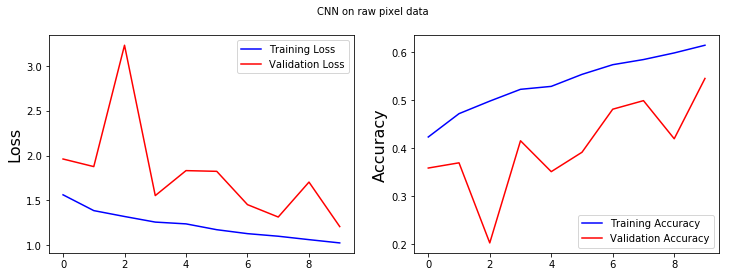

In [22]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.suptitle('CNN on raw pixel data', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(model_history.history['loss'], color='b', label='Training Loss')
plt.plot(model_history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(model_history.history['acc'], color='b', label='Training Accuracy')
plt.plot(model_history.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()
fig.savefig('Loss_comparison_model_arch2.png')


In [14]:
y_predicted_probs = model.predict([x_test, x_test_landmarks], verbose=1)

3589/3589 [==============================] - 15s 4ms/step


In [15]:
score = model.evaluate([x_test, x_test_landmarks], y_test, verbose=1)

3589/3589 [==============================] - 14s 4ms/step


In [16]:
print("Metrics: ", model.metrics_names)
print("Loss on test data", score[0])
print("Test Accuracy", score[1])

Metrics:  ['loss', 'acc']
Loss on test data 1.1701981891460425
Test Accuracy 0.5583728058287014


In [17]:
y_predicted_labels = my_utils.convert_probs_to_labels(y_predicted_probs, labels)
y_actual_labels = my_utils.convert_probs_to_labels(y_test, labels)

Confusion matrix, without normalization
[[365   2   7  33  13  54  17]
 [ 41   6   0   3   0   3   2]
 [170   0  81  32  17 137  91]
 [ 48   0  13 730  19  51  18]
 [189   0   8  58 206 157   8]
 [170   0  23  49  39 305   8]
 [ 32   0  17  35   8  13 311]]


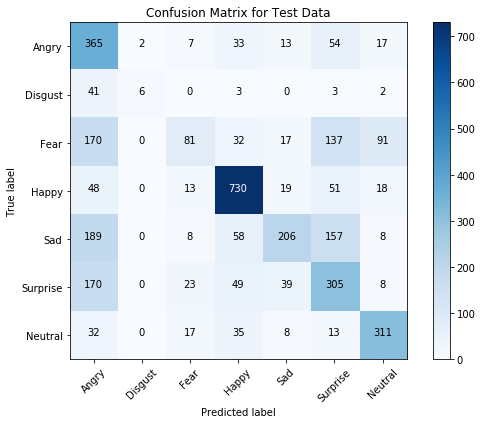

In [19]:
cnf_matrix = sklearn.metrics.confusion_matrix(y_actual_labels, y_predicted_labels)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig = my_utils.plot_confusion_matrix(cnf_matrix, classes=labels,
                                     title='Confusion Matrix for Test Data')
plt.show()
fig.savefig('confusion_matrix_arch2.png')

In [20]:
model.save('model_arch2.h5')

In [21]:
keras.utils.plot_model(model, to_file='model_arch2.png', show_shapes=True)

In [ ]:
def test_for_single_image(file_name, model, labels):
    image_pixels = cv2.imread(file_name, 0)
#     print(len(image_pixels))
    image_input = image_pixels.reshape(-1, 48, 48, 1)
    predicted_emotion = model.predict(image_input, verbose=0)
#     print(predicted_emotion)
    print("This image is classified to be {} with {:.2f}% confidence".format(
        labels[predicted_emotion.argmax()],predicted_emotion.max()*100))
    

In [ ]:
test_for_single_image('100th.jpg', model, labels)

In [ ]:
test_for_single_image('ashok.jpg', model, labels)

In [ ]:
test_for_single_image('ashok2.png', model, labels)

In [ ]:
test_for_single_image('rose2.jpg', model, labels)

In [ ]:
test_for_single_image('rose3.jpg', model, labels)

In [ ]:
test_for_single_image('jose.png', model, labels)

In [ ]:
test_for_single_image('rohit_happy.jpeg', model, labels)

In [ ]:
test_for_single_image('ankita.png', model, labels)